# Importações

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

%matplotlib inline

plt.rcParams["figure.figsize"] = (16,10)

# Configurar dataset

### Baixar dados 

In [25]:
!wget -O fraud.csv https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0

--2021-08-24 21:01:10--  https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/47hd95t7n8hhlgz/fraude.csv [following]
--2021-08-24 21:01:10--  https://www.dropbox.com/s/raw/47hd95t7n8hhlgz/fraude.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbaee481de59b820d4ea8b773ac.dl.dropboxusercontent.com/cd/0/inline/BU1lil3AyQ0enNERdMajxyPgItvxb5S0x47hQxe5tmaVZ7DghD6335R9D3uVrVQpg9_zmw1FR5L2rQ1Ff4t47KcaZWd7lMHw24ygkO062RW8ZlDK2aV0zxvJhXJAre318iBRZrwt25EWdfDiBSMHq4CY/file# [following]
--2021-08-24 21:01:10--  https://ucbaee481de59b820d4ea8b773ac.dl.dropboxusercontent.com/cd/0/inline/BU1lil3AyQ0enNERdMajxyPgItvxb5S0x47hQxe5tmaVZ7DghD6335R9D3uVrVQpg9_zmw1FR5L2rQ1Ff4t47KcaZWd

In [3]:
dataset_path = "fraud.csv"

### Ler CSV

In [4]:
df = pd.read_csv(dataset_path) 

#2 - Testes de Hipótese

### 2.1 - TESTE 1:
**hipoteste nula**: A diferença das médias de ocorrência de fraudes entre Cash_Out e Transfer pode ser explicados pela variabilidade natural

**hipotese alternativa**: A diferença das médias de ocorrência de fraudes entre Cash_Out e Transfer não pode ser explicados pela variabilidade natural

#### Preparação dos dados

In [5]:
data = df.copy()

In [6]:
data["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
data = data[["type", "isFraud"]]
data_media = data.groupby('type').mean()
data_media

,isFraud
type,
CASH_IN,0.000000
CASH_OUT,0.001840
DEBIT,0.000000
PAYMENT,0.000000
TRANSFER,0.007688


Apenas CASH_OUT e TRANSFER possuem fraudes

In [8]:
data = data[data['type'].isin(['CASH_OUT', 'TRANSFER'])]
data_media = data.groupby('type').mean()
data_media

,isFraud
type,
CASH_OUT,0.001840
TRANSFER,0.007688


**Estatística de teste**:

In [9]:
est_teste = data_media.values[1][0]-data_media.values[0][0]
est_teste

0.005848438685817112

#### Teste por permutação

In [10]:
N = 100000 #selecionar aleatoriamente 100 mil instâncias, por questão de tempo
iteracoes = 2000
filtro = data['type'] == 'CASH_OUT'
t_obs = data[filtro]['isFraud'].mean() - data[~filtro]['isFraud'].mean()
data = data.sample(n=N, random_state=123214)
filtro = data['type'] == 'CASH_OUT'
diffs = np.zeros(iteracoes)
for i in range(iteracoes):
    np.random.seed(i)
    np.random.shuffle(filtro.values)
    diffs[i] = data[filtro]['isFraud'].mean() - data[~filtro]['isFraud'].mean()

#### Identificando limites

In [11]:
c_inf = np.percentile(diffs, 2.5)
c_sup = np.percentile(diffs, 97.5)

#### Visualizando resultado

In [12]:
if t_obs<c_sup and t_obs>c_inf:
    print("hipotese nula")
else:
    print("hipotese alternativa")

hipotese alternativa


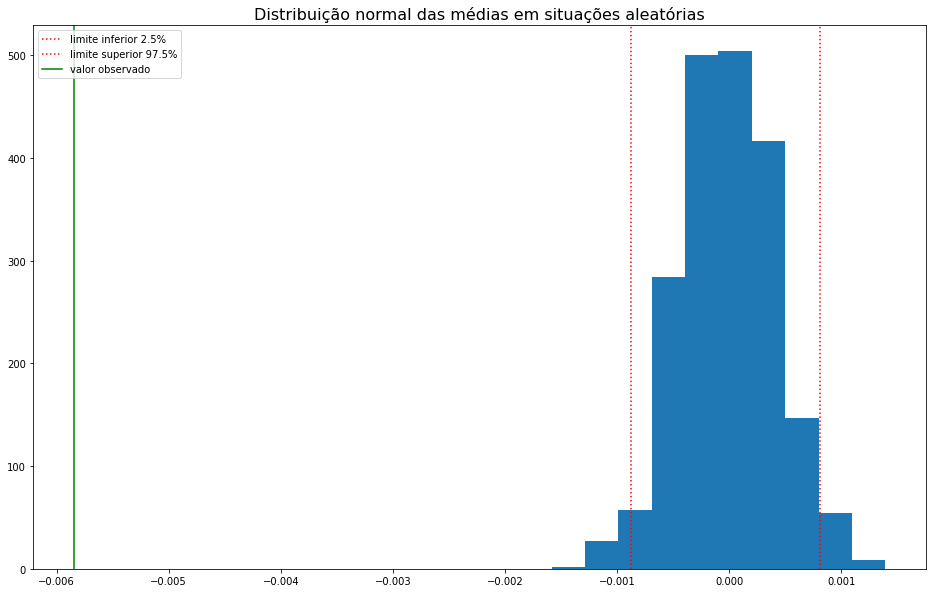

In [26]:
plt.hist(diffs)
inf = plt.axvline(x=c_inf, color = "r", ls = ":", label="limite inferior 2.5%")
sup = plt.axvline(x=c_sup, color = "r", ls = ":", label="limite superior 97.5%")
obs = plt.axvline(x=t_obs, color = "g", ls = "-", label="valor observado")

plt.legend(handles=[inf, sup, obs], loc=2)

plt.title("Distribuição normal das médias em situações aleatórias", fontdict={"fontsize": 16})
plt.show()

### 2.2 - TESTE 2:

Fazendo $1$ como a ocorrência de fraude e $0$ como a não ocorrência de fraude, podemos modelar:

*   O grupo de transações que esgotam o saldo como $X_1, ..., X_m \overset{idd}{\sim} \text{Ber}(p_{total})$;

*   O grupo de transações que não esgotam o saldo como $Y_1, ..., Y_n \overset{idd}{\sim} \text{Ber}(p_{not\;total})$.

Nossa meta é utilizar essas informações para responder a **questão de interesse**: 

**Uma transação que esgota o saldo de uma conta tem maior probabilidade de ser uma fraude?**

Para essa questão, temos respectivamente as hipóteses nula e alternativa:

$\quad \quad H_{0}: p_{total} = p_{not\;total},\quad  H_{1}: p_{total} > p_{not\;total}$ 

O teste adotado para essa hipotese está abaixo:

$\quad \quad \psi = 1\Biggr(\dfrac{2(\overline{X}_m - \overline{Y}_n)}{\sqrt{\frac{1}{m} + \frac{1}{n}}} > 1.96\Biggr)$ 

*a fórmula para esse teste provém de um intervalo de 95% de confiança conservador utilizando o método conservativo*.

Como temos que apenas as transações de saque e de transeferência podem ser consideradas fraudes, vamos aplicar o teste apenas nessas duas ocasiões.

In [14]:
test2 = df.copy()
test2 = test2[test2["type"].isin(["CASH_OUT", "TRANSFER"])][["amount", "oldbalanceOrg", "isFraud"]]
test2["relativeAmount"] = (test2["amount"] / test2["oldbalanceOrg"])

In [15]:
test2Total = test2.query("relativeAmount == 1")
test2TotalFraud = test2Total.query("isFraud == 1")
test2TotalMean = test2TotalFraud.size / test2Total.size
test2TotalMean

1.0

In [16]:
test2NotTotal = test2.query("relativeAmount != 1")
test2NotTotalFraud = test2NotTotal.query("isFraud == 1")
test2NotTotalMean = test2NotTotalFraud.size / test2NotTotal.size
test2NotTotalMean

7.059102060497591e-05

In [17]:
test2Result = 2*(test2TotalMean - test2NotTotalMean)/(((1 / test2Total.size) + (1/test2NotTotal.size))**0.5)
test2Result

357.62921499306043

In [18]:
if(test2Result > 1.96):
  print("Hipotese nula rejeitada.")
else:
  print("Hipotese nula falhou em ser rejeitada")

Hipotese nula rejeitada.


**A hipótese nula foi rejeitada. Portanto uma transação que esgota o saldo de uma conta tem maior probabilidade de ser uma fraude.**

### 2.3 - TESTE 3:

Fazendo $1$ a pessoa que cometeu pelo menos uma fraude e $0$ como a pessoa que não cometeu fraudes, podemos modelar:

*   O grupo amostral de pessoas como $X_1, ..., X_n \overset{idd}{\sim} \text{Ber}(p_{start})$;


Sendo $Y$ o conjunto de pessoas que cometeteram fraudes, faremos agora $1$ para a pessoa que cometeu mais de uma fraude e $0$ para a que apenas cometeu apenas uma. Podemos modelar:

*   As pessoas que cometeram pelo menos uma fraude como $Y_1, ..., Y_m \overset{idd}{\sim} \text{Ber}(p_{after})$.

sendo que $n \geq m$.

Nossa meta é utilizar essas informações para responder a **questão de interesse**: 

**Uma pessoa que originou uma fraude tem tendência a originar novas fraudes?**

Para essa questão, temos respectivamente as hipóteses nula e alternativa:

$\quad \quad H_{0}: p_{start} = p_{after},\quad  H_{1}: p_{start} < p_{after}$ 

O teste adotado para essa hipotese está abaixo:

$\quad \quad \psi = 1\Biggr(\dfrac{2(\overline{Y}_m - \overline{X}_n)}{\sqrt{\frac{1}{m} + \frac{1}{n}}} > 1.96\Biggr)$ 

*a fórmula para esse teste provém de um intervalo de 95% de confiança conservador utilizando o método conservativo*.

Como temos que apenas as transações de saque e de transeferência podem ser consideradas fraudes, vamos aplicar o teste apenas nessas duas ocasiões.

In [19]:
test3Df = df[df["type"].isin(["CASH_OUT", "TRANSFER"])][["nameOrig", "isFraud"]]
test3Df = test3Df.groupby("nameOrig").sum()

In [20]:
def test3(df):
  atLeastOne= df.query("isFraud > 0")
  pStart = atLeastOne.size / df.size
  atLeastTwo = atLeastOne.query("isFraud > 1")
  pAfter = atLeastTwo.size / atLeastOne.size
  result = 2*(pAfter - pStart)/(((1 / df.size) + (1/atLeastOne.size))**0.5)
  return result

In [21]:
if(test3(test3Df) > 1.96):
  print("Hipotese nula rejeitada.")
else:
  print("Hipotese nula falhou em ser rejeitada")

Hipotese nula falhou em ser rejeitada


**A hipótese nula falhou em ser rejeitada**. Contudo, faremos um teste análogo ao último para contas de destinos.

In [22]:
test3Df = df[df["type"].isin(["CASH_OUT", "TRANSFER"])][["nameDest", "isFraud"]]
test3Df = test3Df.groupby("nameDest").sum()

In [23]:
if(test3(test3Df) > 1.96):
  print("Hipotese nula rejeitada.")
else:
  print("Hipotese nula falhou em ser rejeitada")

Hipotese nula falhou em ser rejeitada


**A hipótese nula falhou em ser rejeitada novamente. Portanto o fato de uma origem ou destino já ter se envolvido em uma fraude não aumenta a probabilidade de ocorrências de novas fraudes.**